In [43]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# ETL with NVTabular 

NVTabular is a feature engineering and preprocessing library for tabular data designed to quickly and easily manipulate terabyte scale datasets used to train deep learning based recommender systems.  It provides a high level abstraction to simplify code and accelerates computation on the GPU using the RAPIDS cuDF library.<br><br>

Deep Learning models require the input feature in a specific format. Categorical features needs to be continuous integers (0, ..., |C|) to use them with an embedding layer. We will use NVTabular to preprocess the categorical features.<br><br>

This notebook will prepare the Movielens data for use with HugeCTR training.

In [44]:
# External dependencies
!apt update && apt install -y graphviz

import cudf
import os
import shutil
import numpy as np

import nvtabular as nvt

from os import path

Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
16 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
The following packages were automatically installed and are no longer required:
  cmake-data libarchive13 librhash0 libuv1
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


We define our base input directory, containing the data.

In [45]:
INPUT_DATA_DIR = './data'

In [46]:
movies = cudf.read_parquet(os.path.join(INPUT_DATA_DIR, "movies_converted.parquet"))
movies.head()

movieId
0        1
1        2
2        3
3        4
4        5

### Defining our Preprocessing Pipeline
The first step is to define the feature engineering and preprocessing pipeline.<br><br>
NVTabular has already implemented multiple calculations, called `ops`. An `op` can be applied to a `ColumnGroup` from an overloaded `>>` operator, which in turn returns a new `ColumnGroup`. A `ColumnGroup` is a list of column names as text.<br><br>
**Example:**<br>
```python
features = [ column_name, ...] >> op1 >> op2 >> ...
```

This may sounds more complicated as it is. Let's define our first pipeline for the MovieLens dataset.

Currently, our dataset consists of two separate dataframes. First, we use the `JoinExternal` operator to `left-join` the metadata (genres) to our rating dataset.

In [47]:
CATEGORICAL_COLUMNS = ["userId", "movieId"]
LABEL_COLUMNS = ["rating"]

In [48]:
joined = ["userId", "movieId"] >> nvt.ops.JoinExternal(movies, on=["movieId"])

Data pipelines are **Directed Acyclic Graphs (DAGs)**. We can visualize them with `graphviz`.

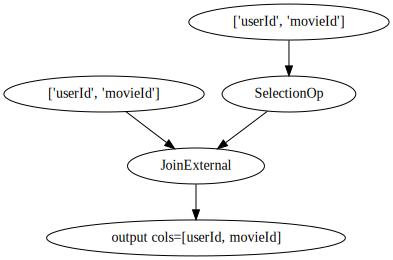

In [49]:
joined.graph

Embedding Layers of neural networks require that categorical features are contiguous, incremental Integers: 0, 1, 2, ... , |C|-1. We need to ensure that our categorical features fullfil the requirement.<br>

Currently, our genres are a list of Strings. In addition, we should transform the single-hot categorical features userId and movieId, as well.<br>
NVTabular provides the operator `Categorify`, which provides this functionality with a high-level API out of the box. In NVTabular release v0.3, list support was added for multi-hot categorical features. Both works in the same way with no need for changes.


Next, we will add `Categorify`  for our categorical features (single hot: userId, movieId and multi-hot: genres).

In [50]:
cat_features = joined >> nvt.ops.Categorify() 
movieId_dup = cat_features["movieId"] >> nvt.ops.Rename(postfix='_duplicate')

The ratings are on a scale between 1-5. We want to predict a binary target with 1 for ratings `>3` and 0 for  ratings `<=3`. We use the [LambdaOp](https://nvidia-merlin.github.io/NVTabular/main/api/ops/lambdaop.html) for it.

In [51]:
ratings = nvt.ColumnGroup(["rating"]) >> (lambda col: (col > 3).astype("int8"))

We will also be adding a duplicate of the `movieId` field, which will be used for looking up pretrained movie embedding features.

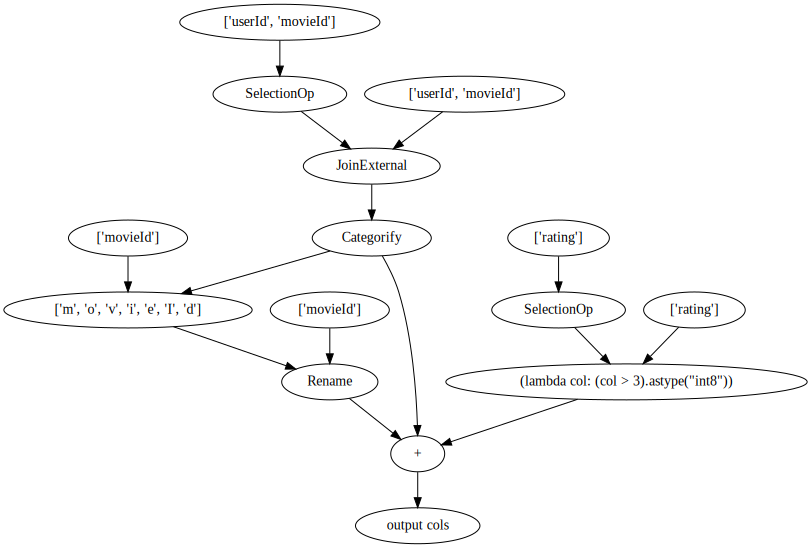

In [52]:
output = cat_features + ratings + movieId_dup
(output).graph

We initialize our NVTabular `workflow`.

In [53]:
workflow = nvt.Workflow(output)

### Running the pipeline

In general, the `Op`s in our `Workflow` will require measurements of statistical properties of our data in order to be leveraged. For example, the `Normalize` op requires measurements of the dataset mean and standard deviation, and the `Categorify` op requires an accounting of all the categories a particular feature can manifest. However, we frequently need to measure these properties across datasets which are too large to fit into GPU memory (or CPU memory for that matter) at once.

NVTabular solves this by providing the `Dataset` class, which breaks a set of parquet or csv files into into a collection of `cudf.DataFrame` chunks that can fit in device memory. The main purpose of this class is to abstract away the raw format of the data, and to allow other NVTabular classes to reliably materialize a dask_cudf.DataFrame collection (and/or collection-based iterator) on demand. Under the hood, the data decomposition corresponds to the construction of a [dask_cudf.DataFrame](https://docs.rapids.ai/api/cudf/stable/) object.  By representing our dataset as a lazily-evaluated [Dask](https://dask.org/) collection, we can handle the calculation of complex global statistics (and later, can also iterate over the partitions while feeding data into a neural network). `part_size` defines the size read into GPU-memory at once.

Now instantiate dataset iterators to loop through our dataset (which we couldn't fit into GPU memory). HugeCTR expect the categorical input columns as `int64` and continuous/label columns as `float32` We need to enforce the required HugeCTR data types, so we set them in a dictionary and give as an argument when creating our dataset.

In [54]:
dict_dtypes = {}

for col in CATEGORICAL_COLUMNS:
    dict_dtypes[col] = np.int64

for col in LABEL_COLUMNS:
    dict_dtypes[col] = np.float32

In [55]:
train_dataset = nvt.Dataset([os.path.join(INPUT_DATA_DIR, "train.parquet")], part_size="100MB")
valid_dataset = nvt.Dataset([os.path.join(INPUT_DATA_DIR, "valid.parquet")], part_size="100MB")

/nvtabular/nvtabular/io/parquet.py:285: UserWarning: Row group memory size (640002432) (bytes) of parquet file is bigger than requested part_size (100000000) for the NVTabular dataset.A row group memory size of 128 MB is generally recommended. You can find info on how to set the row group size of parquet files in https://nvidia-merlin.github.io/NVTabular/main/resources/troubleshooting.html#setting-the-row-group-size-for-the-parquet-files
  warnings.warn(
/nvtabular/nvtabular/io/parquet.py:285: UserWarning: Row group memory size (160000608) (bytes) of parquet file is bigger than requested part_size (100000000) for the NVTabular dataset.A row group memory size of 128 MB is generally recommended. You can find info on how to set the row group size of parquet files in https://nvidia-merlin.github.io/NVTabular/main/resources/troubleshooting.html#setting-the-row-group-size-for-the-parquet-files
  warnings.warn(


Now that we have our datasets, we'll apply our `Workflow` to them and save the results out to parquet files for fast reading at train time. Similar to the `scikit learn` API, we collect the statistics of our train dataset with `.fit`.

In [56]:
%%time

workflow.fit(train_dataset)

CPU times: user 554 ms, sys: 427 ms, total: 981 ms
Wall time: 1.04 s


We clear our output directories.

In [57]:
# Make sure we have a clean output path
if path.exists(os.path.join(INPUT_DATA_DIR, "train-hugectr")):
    shutil.rmtree(os.path.join(INPUT_DATA_DIR, "train-hugectr"))
if path.exists(os.path.join(INPUT_DATA_DIR, "valid-hugectr")):
    shutil.rmtree(os.path.join(INPUT_DATA_DIR, "valid-hugectr"))

We transform our workflow with `.transform`. We are going to add only `'userId', 'movieId'` columns to `_metadata.json`, because this json file will be needed for HugeCTR training to obtain the required information from all the rows in each parquet file.

In [58]:
%time
workflow.transform(train_dataset).to_parquet(
    output_path=os.path.join(INPUT_DATA_DIR, "train-hugectr"),
    shuffle=nvt.io.Shuffle.PER_PARTITION,
    cats=["userId", "movieId"],
    labels=["rating"],
    dtypes=dict_dtypes,
)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 5.25 µs


In [59]:
%time
workflow.transform(valid_dataset).to_parquet(
    output_path=os.path.join(INPUT_DATA_DIR, "valid-hugectr"),
    shuffle=False,
    cats=["userId", "movieId"],
    labels=["rating"],
    dtypes=dict_dtypes,
)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.68 µs


We can take a look in the output dir.

In the next notebooks, we will train a deep learning model. Our training pipeline requires information about the data schema to define the neural network architecture. We will save the NVTabular workflow to disk tha we can restore it in the next notebooks.

In [60]:
workflow.save(os.path.join(INPUT_DATA_DIR, "workflow-hugectr"))

In [61]:
from nvtabular.ops import get_embedding_sizes

embeddings = get_embedding_sizes(workflow)
print(embeddings)

{'userId': (162542, 512), 'movieId': (56586, 512), 'movieId_duplicate': (56586, 512)}


### Checking the pre-processing outputs

We can take a look on the data.

In [62]:
import glob

TRAIN_PATHS = sorted(glob.glob(os.path.join(INPUT_DATA_DIR, "train-hugectr", "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(INPUT_DATA_DIR, "valid-hugectr", "*.parquet")))
TRAIN_PATHS, VALID_PATHS

(['./data/train-hugectr/part_0.parquet'],
 ['./data/valid-hugectr/part_0.parquet'])

We can see, that genres are a list of Integers

In [63]:
df = cudf.read_parquet(TRAIN_PATHS[0])
df.head()

userId  movieId  rating  movieId_duplicate
0   26460      874     0.0                874
1   97438     1704     0.0               1704
2  105574     3568     0.0               3568
3   39464       30     1.0                 30
4  127724       98     1.0                 98